# Background

Links:
- [BayesSearchCV](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html)
- [BayesSearchCV Docs Example](https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import randint
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from skopt import BayesSearchCV
from skopt.plots import plot_objective, plot_histogram
from skopt.space import Categorical, Integer
from time import time

plt.style.use("../style.mplstyle")
%matplotlib inline

In [2]:
data = pd.read_csv("../data/cardio.csv", sep=";", index_col=0)
n_samples = 20000
X, y = data.iloc[:n_samples, :-1].values, data.iloc[:n_samples, -1].values
print(f"Number of records         : {X.shape[0]}")
print(f"Number of features        : {X.shape[1]}")
print(f"Count of positive outcomes: {sum(y)} ({sum(y)/len(y)*100:.1f}%)")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
data.sample(10)

Number of records         : 20000
Number of features        : 11
Count of positive outcomes: 9861 (49.3%)


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
38381,17479,2,176,88.0,120,80,1,1,1,0,1,1
36682,21820,1,169,69.0,120,80,1,1,0,0,1,0
47778,20595,1,180,75.0,140,90,1,1,0,0,1,1
90851,21059,1,172,93.0,140,90,1,1,0,0,1,1
91696,22797,1,161,59.0,110,80,1,1,0,0,1,1
97987,20445,2,163,65.0,110,70,1,2,0,0,1,0
44265,23485,1,165,65.0,120,80,1,1,0,0,1,1
22384,19476,1,158,87.0,125,65,1,1,0,0,0,0
30731,21290,1,156,60.0,120,85,3,2,0,0,1,0


In [3]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
model = RandomForestClassifier(random_state=42)

## BayesSearchCV

In [4]:
rf_params = {
    "max_depth": Integer(5, 150),
    "min_samples_leaf": Integer(1, 20),
    "criterion": Categorical(["gini", "entropy"]),  # categorical parameter
}

In [5]:
start = time()

opt = BayesSearchCV(
    model, rf_params, n_iter=32, cv=cv, n_jobs=1, random_state=42, scoring="roc_auc"
)
print(f"Number of iterations: {opt.total_iterations}")  # n_iter * len(rf_params)

best_score, iteration = 0, 0
# callback handler
def on_step(optim_result):
    global best_score
    global iteration
    iteration += 1
    score = opt.best_score_
    if score > best_score:
        best_score = score
        print(f"\nBest score (iteration): {best_score:.4f} ({iteration})")
    elif iteration % 5 == 0:
        print(
            f"Iteration {iteration}, runtime {(time() - start) / 60:.1f} minutes...",
            end="\r",
        )

opt.fit(X_train, y_train, callback=on_step)
end = time()
print(f"\nRun time     : {(end - start) / 60:.1f} minutes")
print(f"Best score     : {opt.best_score_:.4f}")
print(f"Test score     : {opt.score(X_test, y_test):.4f}")
print(f"Best parameters: {opt.best_params_}")

Number of iterations: 96
Best score (iteration): 0.7982 (1)
Best score (iteration): 0.7983 (9)
Iteration 10...
Iteration 20...
Iteration 30...

Run time     : 2.8 minutes
Best score     : 0.7983
Test score     : 0.7933
Best parameters: OrderedDict([('criterion', 'gini'), ('max_depth', 107), ('min_samples_leaf', 18)])


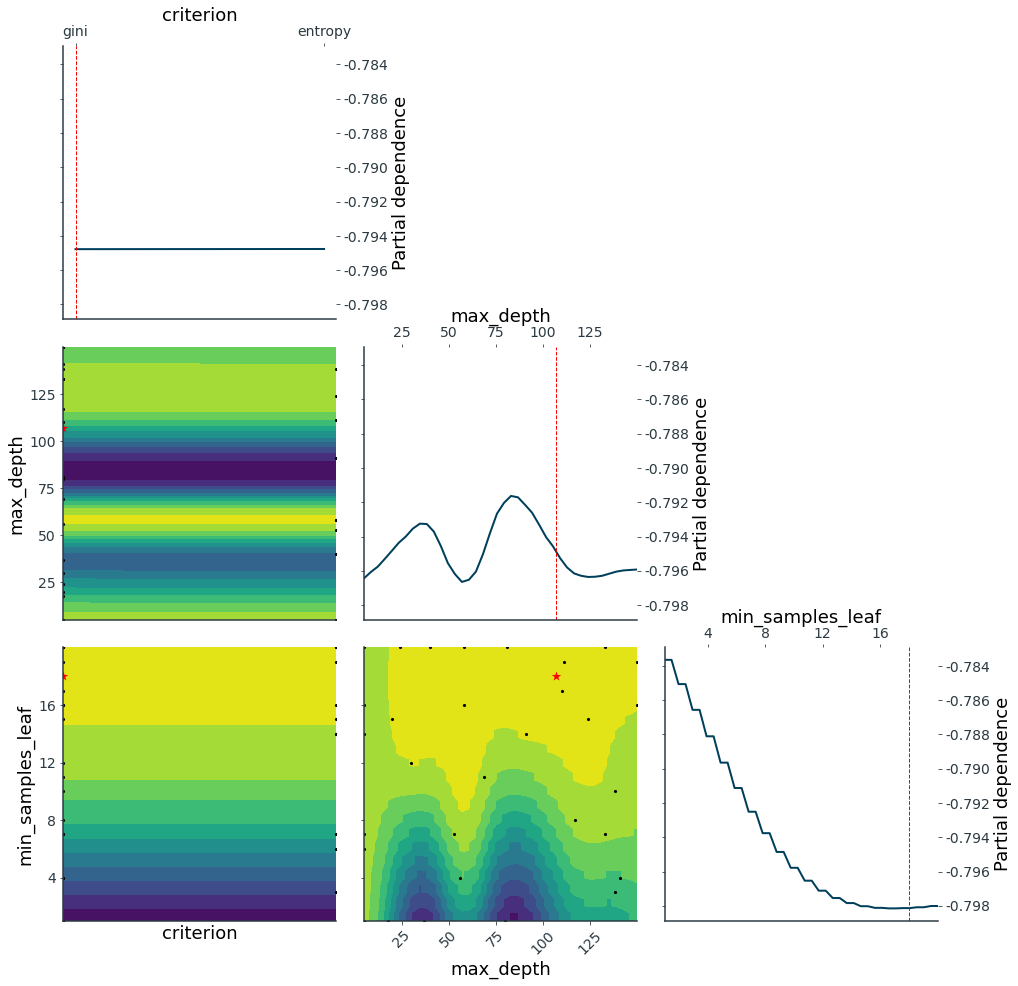

In [6]:
_ = plot_objective(
    opt.optimizer_results_[0],
    dimensions=["criterion", "max_depth", "min_samples_leaf"],
    n_minimum_search=int(1e8),
    size=4.5,
)

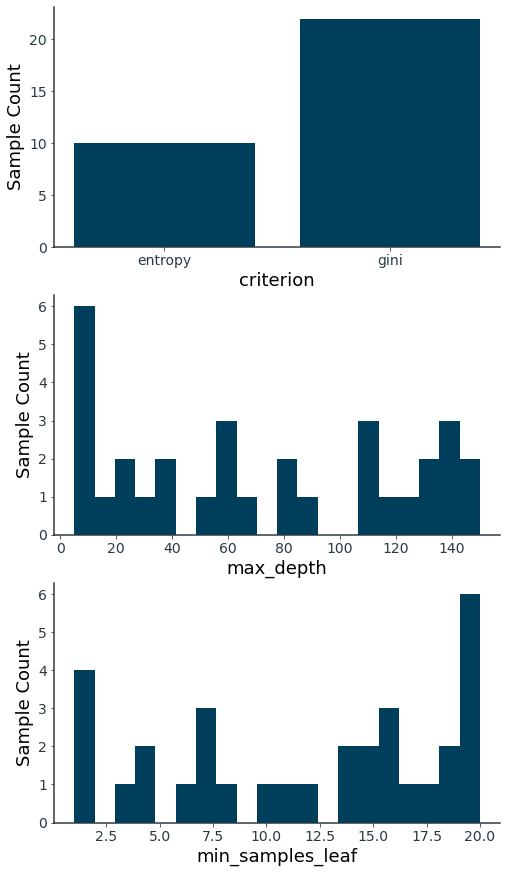

In [7]:
fig, ax = plt.subplots(len(rf_params), 1, figsize=(8, 5*len(rf_params)))
for i in range(len(rf_params)):
    plot_histogram(opt.optimizer_results_[0], i, ax=ax[i])

## RandomizedSearchCV

In [4]:
rf_params_rcv = {
    "max_depth": list(range(10, 150))
    + [0 for _ in range(35)],  # "If a list is given, it is sampled uniformly."
    "min_samples_leaf": randint(1, 20),
    "criterion": ["gini", "entropy"],  # categorical parameter
}

In [5]:
start = time()

opt_rcv = RandomizedSearchCV(
    model,
    rf_params_rcv,
    n_iter=96,
    cv=cv,
    n_jobs=1,
    random_state=42,
    scoring="roc_auc"
)
opt_rcv.fit(X_train, y_train)
end = time()
print(f"\nRun time     : {(end - start) / 60:.1f} minutes")
print(f"Best score     : {opt_rcv.best_score_:.4f}")
print(f"Test score     : {opt_rcv.score(X_test, y_test):.4f}")
print(f"Best parameters: {opt_rcv.best_params_}")


Run time     : 9.4 minutes
Best score     : 0.7988
Test score     : 0.7933
Best parameters: {'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 15}


## GridSearchCV

In [9]:
rf_params_gcv = {
    "max_depth": [5, 12, 25, 50, 100, 150],
    "min_samples_leaf": [1, 4, 10, 20],
    "criterion": ["gini", "entropy"],  # categorical parameter
}

In [10]:
start = time()

opt_gcv = GridSearchCV(
    model,
    rf_params_gcv,
    cv=cv,
    n_jobs=1,
    scoring="roc_auc"
)
opt_gcv.fit(X_train, y_train)
end = time()
print(f"\nRun time     : {(end - start) / 60:.1f} minutes")
print(f"Best score     : {opt_gcv.best_score_:.4f}")
print(f"Test score     : {opt_gcv.score(X_test, y_test):.4f}")
print(f"Best parameters: {opt_gcv.best_params_}")


Run time     : 4.1 minutes
Best score     : 0.7986
Test score     : 0.7936
Best parameters: {'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 20}
